##### dataset: https://physionet.org/content/mitdb/1.0.0/

Dataset has different file formats:

.dat → ECG signal values

.hea → how to read .dat

.atr → where the anomalies are (annotations)

so using wfdb to read these files

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


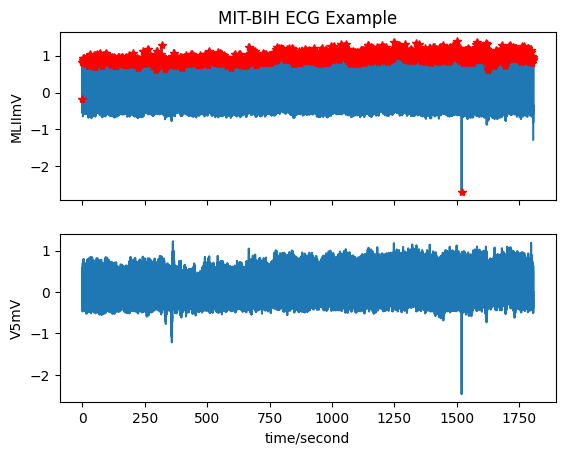

In [2]:
import wfdb
import matplotlib.pyplot as plt

record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')

wfdb.plot_wfdb(record=record, annotation=annotation, title='MIT-BIH ECG Example')

In [3]:
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

record_names = wfdb.get_record_list('mitdb')
print(f"Total {len(record_names)} records found: {record_names}")

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=360):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = filtfilt(b, a, data)
    return y

all_beats = []
all_labels = []
all_rr_intervals = []

for rec in tqdm(record_names, desc="Processing Records"):
    try:
        record = wfdb.rdrecord(rec, pn_dir='mitdb')
        annotation = wfdb.rdann(rec, 'atr', pn_dir='mitdb')

        fs = record.fs

        signal = record.p_signal[:, 0]
        filtered = bandpass_filter(signal, fs=record.fs)

        rr_samples = np.diff(annotation.sample, prepend=0)

        for i in range(len(annotation.sample) - 1):

            start_idx = annotation.sample[i]
            end_idx = annotation.sample[i + 1]

            beat = filtered[start_idx:end_idx]

            if i == 0:
                continue

            all_beats.append(beat)
            all_labels.append(annotation.symbol[i])

            all_rr_intervals.append(rr_samples[i] / fs)

    except Exception as e:
        print(f"Error reading record {rec}: {e}")

norm_beats = [ (b - np.mean(b)) / np.std(b) for b in all_beats ]

padded_beats = pad_sequences(norm_beats, dtype='float32', padding='post', maxlen=200)

df = pd.DataFrame(padded_beats)

df['label'] = all_labels
df['rr_interval_sec'] = all_rr_intervals

print(f"\nFinal dataset shape: {df.shape}")
display(df.head())

df.to_csv('mitbih_all_processed_corrected.csv', index=False)

Total 48 records found: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


Processing Records: 100%|██████████| 48/48 [07:57<00:00,  9.94s/it]



Final dataset shape: (112551, 202)


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,label,rr_interval_sec
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,-0.691603,-0.023417,0.964214,2.242639,3.716783,5.222131,6.543328,7.455434,N,0.163889
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,-1.355380,-1.155956,-0.619900,0.313606,1.630171,3.210836,4.826827,6.173148,N,0.813889
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458432,-0.469523,-0.477511,...,-1.496228,-1.170938,-0.563756,0.373670,1.633945,3.120550,4.634881,5.901722,N,0.811111
3,-0.372888,-0.373257,-0.370062,-0.363881,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,-1.463893,-1.144863,-0.437834,0.682065,2.141524,3.752559,5.231676,6.262034,N,0.788889
4,-0.611277,-0.640649,-0.669551,-0.698467,-0.726677,-0.751649,-0.769012,-0.773858,-0.763394,-0.739517,...,-1.233764,-0.776904,0.063810,1.299796,2.840197,4.477663,5.914838,6.835203,N,0.791667


In [4]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

df = pd.read_csv('mitbih_all_processed_corrected.csv')

y_labels = df['label']
y_rr_intervals = df['rr_interval_sec']
X_signal = df.drop(columns=['label', 'rr_interval_sec'])

def extract_all_features(beat):
    stat_features = {
        'mean': np.mean(beat),
        'std': np.std(beat),
        'min': np.min(beat),
        'max': np.max(beat),
        'energy': np.sum(np.square(beat)),
        'skewness': skew(beat),
        'kurtosis': kurtosis(beat)
    }

    peaks, _ = find_peaks(beat, distance=30)
    if len(peaks) > 0:
        r_peak_amplitude = beat[peaks].max()
    else:
        r_peak_amplitude = np.nan

    stat_features['r_peak_amplitude'] = r_peak_amplitude

    return stat_features

feature_list = []
for row in tqdm(X_signal.values, desc="Extracting Features"):
    feature_list.append(extract_all_features(row))

stat_df = pd.DataFrame(feature_list)

df_features = pd.concat([X_signal, stat_df], axis=1)
df_features['rr_interval_sec'] = y_rr_intervals
df_features['label'] = y_labels

print("\nFinal Feature Matrix Shape:", df_features.shape)
display(df_features.head())

df_features.to_csv("mitbih_all_features_corrected.csv", index=False)

Extracting Features: 100%|██████████| 112551/112551 [02:43<00:00, 687.41it/s]



Final Feature Matrix Shape: (112551, 210)


,0,1,2,3,4,5,6,7,8,9,...,mean,std,min,max,energy,skewness,kurtosis,r_peak_amplitude,rr_interval_sec,label
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,0.145604,0.903450,-1.187726,7.455434,167.484518,5.585946,37.480131,0.687463,0.163889,N
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,0.040831,0.710242,-1.355380,6.173148,101.222049,5.026527,37.604101,0.618417,0.813889,N
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458431,-0.469523,-0.477511,...,0.005573,0.703167,-1.609934,5.901722,98.894869,4.540254,33.880291,0.525573,0.811111,N
3,-0.372888,-0.373258,-0.370062,-0.363882,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,0.038057,0.727066,-1.482621,6.262034,106.014790,5.566994,40.971107,0.495532,0.788889,N
4,-0.611277,-0.640649,-0.669551,-0.698467,-0.726676,-0.751649,-0.769012,-0.773858,-0.763394,-0.739517,...,0.075960,0.841944,-1.383365,6.835203,142.927921,5.001609,33.927868,0.715595,0.791667,N


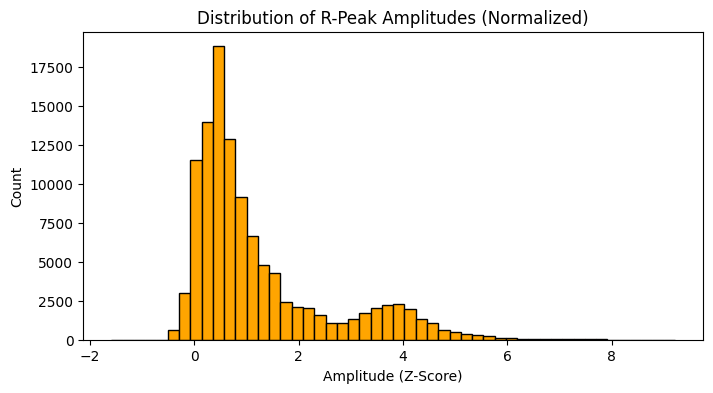

In [5]:
df = pd.read_csv("mitbih_all_features_corrected.csv")

plt.figure(figsize=(8, 4))
plt.hist(df['r_peak_amplitude'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title("Distribution of R-Peak Amplitudes (Normalized)")
plt.xlabel("Amplitude (Z-Score)")
plt.ylabel("Count")
plt.show()

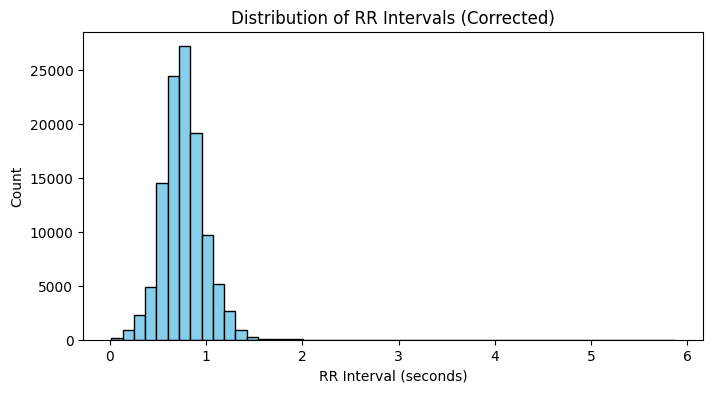

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(df['rr_interval_sec'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of RR Intervals (Corrected)")
plt.xlabel("RR Interval (seconds)")
plt.ylabel("Count")
plt.show()

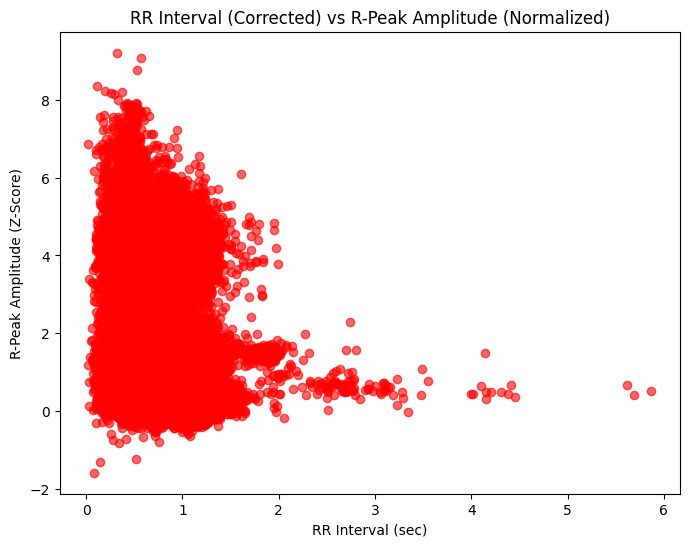

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(df['rr_interval_sec'], df['r_peak_amplitude'], c='red', alpha=0.6)
plt.title("RR Interval (Corrected) vs R-Peak Amplitude (Normalized)")
plt.xlabel("RR Interval (sec)")
plt.ylabel("R-Peak Amplitude (Z-Score)")
plt.show()

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from tqdm import tqdm

def extract_spectral_energy(beat, fs=360):
    f, t, Sxx = spectrogram(beat, fs=fs, nperseg=32)
    spectral_energy = np.sum(Sxx)

    return spectral_energy

df_final = pd.read_csv('mitbih_all_features_corrected.csv')

signal_cols = [str(i) for i in range(200)]
X_signal = df_final[signal_cols]

spectral_features = []
for index, row in tqdm(X_signal.iterrows(), total=len(X_signal), desc="Extracting Spectral Features"):
    beat = row.values

    energy = extract_spectral_energy(beat, fs=360)
    spectral_features.append(energy)

df_spectral = pd.DataFrame({'spectral_energy': spectral_features})

df_final = pd.concat([df_final, df_spectral], axis=1)

print("\nFinal Feature Matrix Shape with Spectral Features:", df_final.shape)
display(df_final.head())

df_final.to_csv("mitbih_final_complete_features.csv", index=False)

Extracting Spectral Features: 100%|██████████| 112551/112551 [00:39<00:00, 2874.71it/s]



Final Feature Matrix Shape with Spectral Features: (112551, 211)


,0,1,2,3,4,5,6,7,8,9,...,std,min,max,energy,skewness,kurtosis,r_peak_amplitude,rr_interval_sec,label,spectral_energy
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,0.903450,-1.187726,7.455434,167.484518,5.585946,37.480131,0.687463,0.163889,N,0.218969
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,0.710242,-1.355380,6.173148,101.222049,5.026527,37.604101,0.618417,0.813889,N,0.113229
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458431,-0.469523,-0.477511,...,0.703167,-1.609934,5.901722,98.894869,4.540254,33.880291,0.525573,0.811111,N,0.125893
3,-0.372888,-0.373258,-0.370062,-0.363882,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,0.727066,-1.482621,6.262034,106.014790,5.566994,40.971107,0.495532,0.788889,N,0.133818
4,-0.611277,-0.640649,-0.669551,-0.698467,-0.726676,-0.751649,-0.769012,-0.773858,-0.763394,-0.739517,...,0.841944,-1.383365,6.835203,142.927921,5.001609,33.927868,0.715595,0.791667,N,0.178282


In [10]:
### Import required libraies
import os, json
from tqdm import tqdm
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb_module

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [12]:
### Config
CSV_PATH = "mitbih_final_complete_features.csv"
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

RAW_SIGNAL_LEN = 200   # expected columns '0'..'199'
RANDOM_STATE = 42
TEST_SIZE = 0.15
SKFOLD = 5
BATCH_SIZE = 128
EPOCHS = 40

# Ensemble weights (final prob = w_meta*meta_prob + w_hybrid*hybrid_prob)
W_META = 0.5
W_HYBRID = 0.5

# Label mapping
NORMAL_SYMBOLS = set(['N','L','R','e','j'])  # mapping these to Normal=0; everything else -> Abnormal=1

In [13]:
### Load data
print("Loading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), "Columns:", len(df.columns))

# check signal columns
signal_cols = [str(i) for i in range(RAW_SIGNAL_LEN)]
for c in signal_cols:
    if c not in df.columns:
        raise RuntimeError(f"Signal column '{c}' missing. Check RAW_SIGNAL_LEN / CSV content.")

# select tabular features (auto-detect)
tabular_candidates = ['mean','std','min','max','energy','skewness','kurtosis', 'r_peak_amplitude','rr_interval_sec','spectral_energy']
tabular_cols = [c for c in tabular_candidates if c in df.columns]
if len(tabular_cols) == 0:
    raise RuntimeError("No tabular feature columns found. Adjust `tabular_candidates`.")
print("Using tabular features:", tabular_cols)

# build X and y
X_signal = df[signal_cols].astype(np.float32).values
X_tabular = df[tabular_cols].fillna(0).astype(np.float32).values
y_symbols = df['label'].astype(str).values

# map to binary: 0 normal, 1 abnormal
y_binary = np.array([0 if s in NORMAL_SYMBOLS else 1 for s in y_symbols], dtype=np.int32)
print("Binary label distribution (0=Normal, 1=Abnormal):", np.bincount(y_binary))

# Save mapping for future
mapping_info = {"normal_symbols": list(NORMAL_SYMBOLS)}
with open(os.path.join(MODEL_DIR, "label_mapping.json"), "w") as f:
    json.dump(mapping_info, f, indent=2)

Loading CSV: mitbih_final_complete_features.csv
Rows: 112551 Columns: 211
Using tabular features: ['mean', 'std', 'min', 'max', 'energy', 'skewness', 'kurtosis', 'r_peak_amplitude', 'rr_interval_sec', 'spectral_energy']
Binary label distribution (0=Normal, 1=Abnormal): [90589 21962]


In [14]:
### Train test split
Xsig_train, Xsig_test, Xtab_train, Xtab_test, y_train, y_test = train_test_split(
    X_signal, X_tabular, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_binary
)
print("Train/Test shapes:", Xsig_train.shape, Xsig_test.shape)

# scale tabular features
scaler = StandardScaler()
Xtab_train_scaled = scaler.fit_transform(Xtab_train)
Xtab_test_scaled = scaler.transform(Xtab_test)
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler_tab.pkl"))
print("Saved tabular scaler.")

Train/Test shapes: (95668, 200) (16883, 200)
Saved tabular scaler.


In [18]:
### Stacking (binary) using StratifiedKFold
skf = StratifiedKFold(n_splits=SKFOLD, shuffle=True, random_state=RANDOM_STATE)

# Base learner params
rf_params = {'n_estimators': 300, 'max_depth': 15, 'random_state': RANDOM_STATE, 'n_jobs': -1}

# XGBoost params
xgb_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': RANDOM_STATE,
}

lgb_params = {'objective': 'binary', 'metric': 'binary_logloss',
              'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.8,
              'bagging_fraction': 0.8, 'bagging_freq': 5, 'seed': RANDOM_STATE}

n_train = Xtab_train_scaled.shape[0]
n_test = Xtab_test_scaled.shape[0]

oof_train = np.zeros((n_train, 3))
oof_test = np.zeros((n_test, 3))

print("\nStarting stacking OOF generation...")
for fold, (tr_idx, val_idx) in enumerate(skf.split(Xtab_train_scaled, y_train)):
    print(f"\n--- Fold {fold+1}/{SKFOLD} ---")
    X_tr, X_val = Xtab_train_scaled[tr_idx], Xtab_train_scaled[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    # Random Forest
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    oof_train[val_idx, 0] = rf.predict_proba(X_val)[:,1]
    oof_test[:, 0] += rf.predict_proba(Xtab_test_scaled)[:,1] / SKFOLD

    # XGBoost
    xgb_clf = XGBClassifier(**xgb_params)
    try:
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    except TypeError:
        try:
            xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[xgb_module.callback.EarlyStopping(rounds=50)], verbose=False)
        except Exception:
            xgb_clf.fit(X_tr, y_tr, verbose=False)
    oof_train[val_idx, 1] = xgb_clf.predict_proba(X_val)[:,1]
    oof_test[:, 1] += xgb_clf.predict_proba(Xtab_test_scaled)[:,1] / SKFOLD

    # LightGBM
    lgb_tr = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_tr)
    lgb_model = lgb.train(params=lgb_params, train_set=lgb_tr, valid_sets=[lgb_val],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(stopping_rounds=50),
                                     lgb.log_evaluation(period=100)])
    oof_train[val_idx, 2] = lgb_model.predict(X_val)
    oof_test[:, 2] += lgb_model.predict(Xtab_test_scaled) / SKFOLD

    del rf, xgb_clf, lgb_model

print("\nOut Of Fold prediction generation complete. Training meta-learner (Logistic Regression)...")
meta_lr = LogisticRegression(max_iter=2000)
meta_lr.fit(oof_train, y_train)

meta_test_feats = np.zeros((n_test, 3))
meta_test_feats[:,0] = oof_test[:,0]
meta_test_feats[:,1] = oof_test[:,1]
meta_test_feats[:,2] = oof_test[:,2]

meta_test_probs = meta_lr.predict_proba(meta_test_feats)[:,1]
meta_test_preds = (meta_test_probs >= 0.5).astype(int)
print("\nMeta (stacked) Test Metrics:")
print(classification_report(y_test, meta_test_preds, target_names=['Normal','Abnormal']))
print("Meta Accuracy:", accuracy_score(y_test, meta_test_preds))


Starting stacking OOF generation...

--- Fold 1/5 ---
[LightGBM] [Info] Number of positive: 14934, number of negative: 61600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 76534, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195129 -> initscore=-1.417021
[LightGBM] [Info] Start training from score -1.417021
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.132074
[200]	valid_0's binary_logloss: 0.110284
[300]	valid_0's binary_logloss: 0.0999446
[400]	valid_0's binary_logloss: 0.0935743
[500]	valid_0's binary_logloss: 0.0896373
[600]	valid_0's binary_logloss: 0.0868039
[700]	valid_0's binary_logloss: 0.0846271
[800]	valid_0's binary_logloss: 0.0832317
[900]	valid_0's binary_logloss: 0.0820839
[1000]	valid_0

In [19]:
### Train full base models for saving
rf_full = RandomForestClassifier(**rf_params)
rf_full.fit(Xtab_train_scaled, y_train)
joblib.dump(rf_full, os.path.join(MODEL_DIR, "rf_full.pkl"))

xgb_full = XGBClassifier(**xgb_params)
try:
    xgb_full.fit(Xtab_train_scaled, y_train, eval_set=[(Xtab_test_scaled, y_test)], early_stopping_rounds=50, verbose=False)
except TypeError:
    try:
        xgb_full.fit(Xtab_train_scaled, y_train, eval_set=[(Xtab_test_scaled, y_test)], callbacks=[xgb_module.callback.EarlyStopping(rounds=50)], verbose=False)
    except Exception:
        xgb_full.fit(Xtab_train_scaled, y_train, verbose=False)
joblib.dump(xgb_full, os.path.join(MODEL_DIR, "xgb_full.pkl"))

lgb_full = lgb.train(params=lgb_params, train_set=lgb.Dataset(Xtab_train_scaled, label=y_train),
                     valid_sets=[lgb.Dataset(Xtab_test_scaled, label=y_test)],
                     num_boost_round=1000,
                     callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)])
lgb_full.save_model(os.path.join(MODEL_DIR, "lgb_full.txt"))

joblib.dump(meta_lr, os.path.join(MODEL_DIR, "meta_lr.pkl"))

[LightGBM] [Info] Number of positive: 18668, number of negative: 77000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 95668, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195133 -> initscore=-1.416995
[LightGBM] [Info] Start training from score -1.416995
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.136001
[200]	valid_0's binary_logloss: 0.114877
[300]	valid_0's binary_logloss: 0.105958
[400]	valid_0's binary_logloss: 0.100278
[500]	valid_0's binary_logloss: 0.0961953
[600]	valid_0's binary_logloss: 0.0936695
[700]	valid_0's binary_logloss: 0.0913932
[800]	valid_0's binary_logloss: 0.0895539
[900]	valid_0's binary_logloss: 0.0879933
[1000]	valid_0's binary_logloss: 0.0873766
Did not meet early stopping.

['saved_models/meta_lr.pkl']

In [23]:
### Hybrid CNN+biLSTM model
def build_hybrid_model(signal_len=RAW_SIGNAL_LEN, tab_dim=Xtab_train_scaled.shape[1]):
    inp_signal = layers.Input(shape=(signal_len,1), name="signal_input")
    x = layers.Conv1D(32, kernel_size=7, padding='same', activation='relu')(inp_signal)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    inp_tab = layers.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(64, activation='relu')(inp_tab)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(0.2)(t)
    t = layers.Dense(32, activation='relu')(t)

    m = layers.Concatenate()([x, t])
    m = layers.Dense(128, activation='relu')(m)
    m = layers.Dropout(0.3)(m)
    out = layers.Dense(1, activation='sigmoid')(m)

    return models.Model(inputs=[inp_signal, inp_tab], outputs=out)

hybrid = build_hybrid_model()
hybrid.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
               loss='binary_crossentropy', metrics=['accuracy'])

Xsig_train_cnn = Xsig_train.reshape((-1, RAW_SIGNAL_LEN, 1))
Xsig_test_cnn = Xsig_test.reshape((-1, RAW_SIGNAL_LEN, 1))

cw_vals = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw_vals[i] for i in range(len(cw_vals))}

hybrid_ckpt = os.path.join(MODEL_DIR, "hybrid_best_binary.h5")
cb_list = [
    callbacks.ModelCheckpoint(hybrid_ckpt, monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
]

Xsig_tr_fit, Xsig_val_fit, Xtab_tr_fit, Xtab_val_fit, y_tr_fit, y_val_fit = train_test_split(
    Xsig_train_cnn, Xtab_train_scaled, y_train, test_size=0.12, random_state=RANDOM_STATE, stratify=y_train
)

history = hybrid.fit(
    {"signal_input": Xsig_tr_fit, "tab_input": Xtab_tr_fit},
    y_tr_fit,
    validation_data=({"signal_input": Xsig_val_fit, "tab_input": Xtab_val_fit}, y_val_fit),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=cb_list,
    verbose=2
)

hybrid.save(os.path.join(MODEL_DIR, "hybrid_final_binary.h5"))

hybrid_best = models.load_model(hybrid_ckpt)
hybrid_probs = hybrid_best.predict({"signal_input": Xsig_test_cnn, "tab_input": Xtab_test_scaled}, batch_size=256).ravel()
hybrid_preds = (hybrid_probs >= 0.5).astype(int)

Epoch 1/40


658/658 - 21s - 32ms/step - accuracy: 0.9319 - loss: 0.1889 - val_accuracy: 0.9497 - val_loss: 0.1204 - learning_rate: 1.0000e-03
Epoch 2/40
658/658 - 15s - 23ms/step - accuracy: 0.9591 - loss: 0.1156 - val_accuracy: 0.9551 - val_loss: 0.1228 - learning_rate: 1.0000e-03
Epoch 3/40


658/658 - 9s - 13ms/step - accuracy: 0.9683 - loss: 0.0920 - val_accuracy: 0.9711 - val_loss: 0.0784 - learning_rate: 1.0000e-03
Epoch 4/40


658/658 - 10s - 15ms/step - accuracy: 0.9729 - loss: 0.0780 - val_accuracy: 0.9771 - val_loss: 0.0646 - learning_rate: 1.0000e-03
Epoch 5/40
658/658 - 10s - 15ms/step - accuracy: 0.9753 - loss: 0.0719 - val_accuracy: 0.9730 - val_loss: 0.0772 - learning_rate: 1.0000e-03
Epoch 6/40
658/658 - 10s - 15ms/step - accuracy: 0.9781 - loss: 0.0623 - val_accuracy: 0.9744 - val_loss: 0.0743 - learning_rate: 1.0000e-03
Epoch 7/40
658/658 - 10s - 15ms/step - accuracy: 0.9787 - loss: 0.0603 - val_accuracy: 0.9740 - val_loss: 0.0717 - learning_rate: 1.0000e-03
Epoch 8/40


658/658 - 9s - 14ms/step - accuracy: 0.9808 - loss: 0.0524 - val_accuracy: 0.9787 - val_loss: 0.0610 - learning_rate: 1.0000e-03
Epoch 9/40


658/658 - 10s - 15ms/step - accuracy: 0.9810 - loss: 0.0526 - val_accuracy: 0.9814 - val_loss: 0.0529 - learning_rate: 1.0000e-03
Epoch 10/40
658/658 - 10s - 15ms/step - accuracy: 0.9822 - loss: 0.0480 - val_accuracy: 0.9763 - val_loss: 0.0681 - learning_rate: 1.0000e-03
Epoch 11/40
658/658 - 10s - 15ms/step - accuracy: 0.9839 - loss: 0.0440 - val_accuracy: 0.9810 - val_loss: 0.0564 - learning_rate: 1.0000e-03
Epoch 12/40
658/658 - 9s - 13ms/step - accuracy: 0.9837 - loss: 0.0439 - val_accuracy: 0.9765 - val_loss: 0.0658 - learning_rate: 1.0000e-03
Epoch 13/40
658/658 - 10s - 15ms/step - accuracy: 0.9848 - loss: 0.0430 - val_accuracy: 0.9816 - val_loss: 0.0564 - learning_rate: 1.0000e-03
Epoch 14/40
658/658 - 10s - 15ms/step - accuracy: 0.9855 - loss: 0.0398 - val_accuracy: 0.9814 - val_loss: 0.0552 - learning_rate: 1.0000e-03
Epoch 15/40


658/658 - 10s - 15ms/step - accuracy: 0.9862 - loss: 0.0362 - val_accuracy: 0.9831 - val_loss: 0.0521 - learning_rate: 1.0000e-03
Epoch 16/40
658/658 - 9s - 13ms/step - accuracy: 0.9871 - loss: 0.0350 - val_accuracy: 0.9811 - val_loss: 0.0561 - learning_rate: 1.0000e-03
Epoch 17/40
658/658 - 10s - 15ms/step - accuracy: 0.9872 - loss: 0.0345 - val_accuracy: 0.9815 - val_loss: 0.0543 - learning_rate: 1.0000e-03
Epoch 18/40
658/658 - 10s - 15ms/step - accuracy: 0.9881 - loss: 0.0325 - val_accuracy: 0.9801 - val_loss: 0.0597 - learning_rate: 1.0000e-03
Epoch 19/40
658/658 - 10s - 15ms/step - accuracy: 0.9892 - loss: 0.0302 - val_accuracy: 0.9838 - val_loss: 0.0536 - learning_rate: 1.0000e-03
Epoch 20/40
658/658 - 9s - 14ms/step - accuracy: 0.9886 - loss: 0.0301 - val_accuracy: 0.9834 - val_loss: 0.0547 - learning_rate: 1.0000e-03
Epoch 21/40

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
658/658 - 11s - 16ms/step - accuracy: 0.9886 - loss: 0.0298 - val_accura

658/658 - 10s - 15ms/step - accuracy: 0.9914 - loss: 0.0225 - val_accuracy: 0.9855 - val_loss: 0.0519 - learning_rate: 5.0000e-04
Epoch 23/40
658/658 - 10s - 15ms/step - accuracy: 0.9934 - loss: 0.0175 - val_accuracy: 0.9846 - val_loss: 0.0587 - learning_rate: 5.0000e-04
Epoch 24/40
658/658 - 10s - 15ms/step - accuracy: 0.9937 - loss: 0.0166 - val_accuracy: 0.9852 - val_loss: 0.0597 - learning_rate: 5.0000e-04
Epoch 25/40
658/658 - 9s - 14ms/step - accuracy: 0.9941 - loss: 0.0157 - val_accuracy: 0.9867 - val_loss: 0.0555 - learning_rate: 5.0000e-04
Epoch 26/40
658/658 - 9s - 14ms/step - accuracy: 0.9946 - loss: 0.0144 - val_accuracy: 0.9848 - val_loss: 0.0632 - learning_rate: 5.0000e-04
Epoch 27/40
658/658 - 10s - 15ms/step - accuracy: 0.9942 - loss: 0.0153 - val_accuracy: 0.9856 - val_loss: 0.0560 - learning_rate: 5.0000e-04
Epoch 28/40

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
658/658 - 10s - 15ms/step - accuracy: 0.9948 - loss: 0.0142 - val_accura

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step



All done. Saved models & artifacts in: saved_models


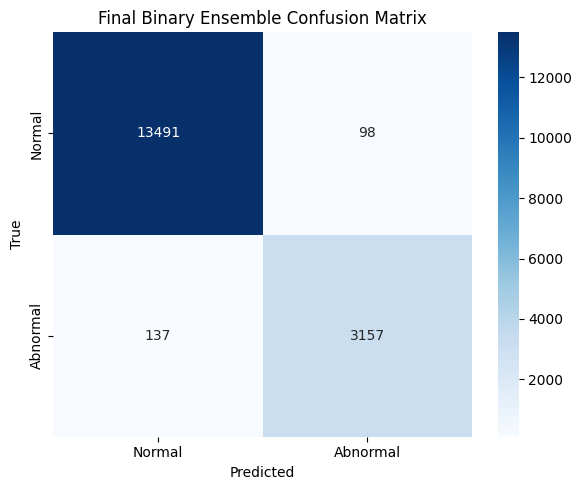

In [24]:
### Final Ensemble
meta_test_feats[:,0] = rf_full.predict_proba(Xtab_test_scaled)[:,1]
meta_test_feats[:,1] = xgb_full.predict_proba(Xtab_test_scaled)[:,1]
meta_test_feats[:,2] = lgb_full.predict(Xtab_test_scaled)

meta_probs = meta_lr.predict_proba(meta_test_feats)[:,1]
final_probs = W_META * meta_probs + W_HYBRID * hybrid_probs
final_preds = (final_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Binary Ensemble Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "final_confusion_matrix_binary.png"))

artifacts = {
    "scaler_tab": os.path.join(MODEL_DIR, "scaler_tab.pkl"),
    "rf_full": os.path.join(MODEL_DIR, "rf_full.pkl"),
    "xgb_full": os.path.join(MODEL_DIR, "xgb_full.pkl"),
    "lgb_full": os.path.join(MODEL_DIR, "lgb_full.txt"),
    "meta_lr": os.path.join(MODEL_DIR, "meta_lr.pkl"),
    "hybrid_best": hybrid_ckpt,
    "hybrid_final": os.path.join(MODEL_DIR, "hybrid_final_binary.h5"),
    "label_mapping": os.path.join(MODEL_DIR, "label_mapping.json")
}
with open(os.path.join(MODEL_DIR, "artifacts.json"), "w") as f:
    json.dump(artifacts, f, indent=2)

print("\nAll done. Saved models & artifacts in:", MODEL_DIR)

Final (meta-stacked) Test Metrics
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     13589
    Abnormal       0.95      0.89      0.91      3294

    accuracy                           0.97     16883
   macro avg       0.96      0.94      0.95     16883
weighted avg       0.97      0.97      0.97     16883

Accuracy: 0.9677782384647279


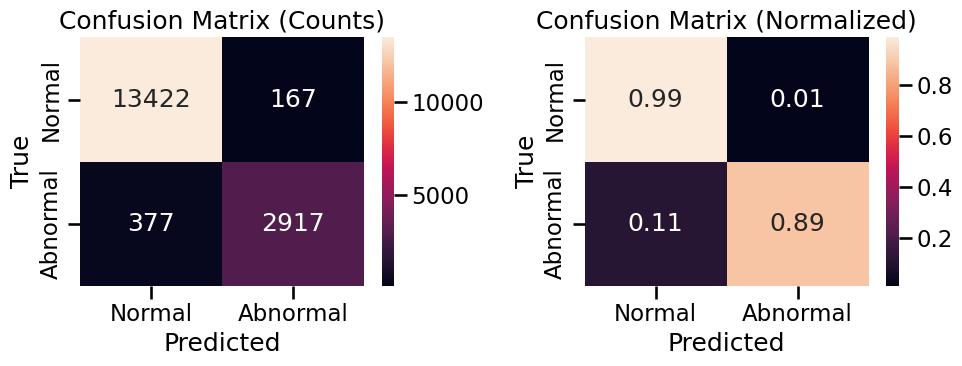

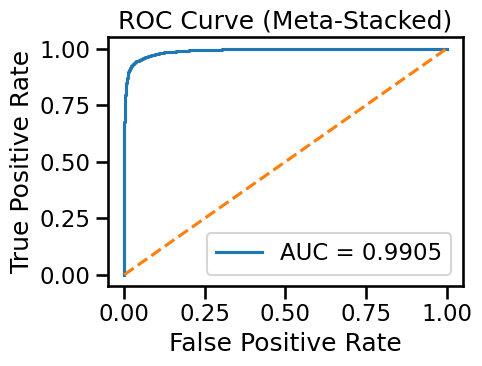

<Figure size 640x480 with 0 Axes>

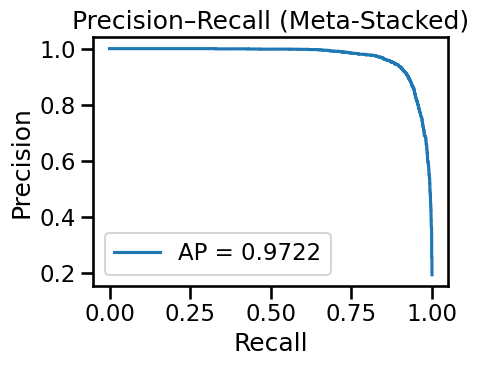


Plotting True Positives (predicted Abnormal, actually Abnormal):


<Figure size 640x480 with 0 Axes>

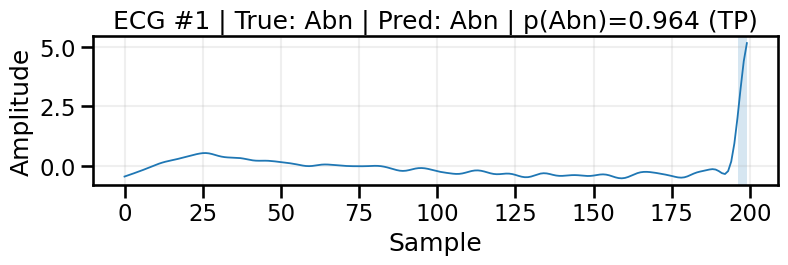

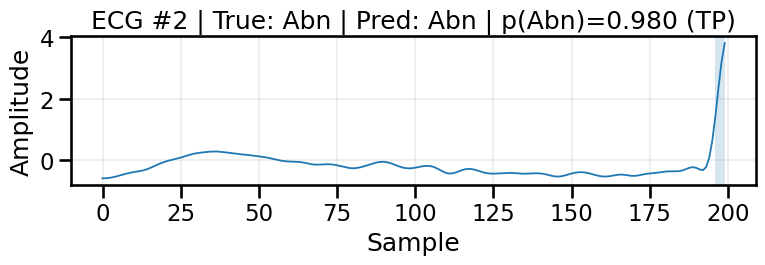

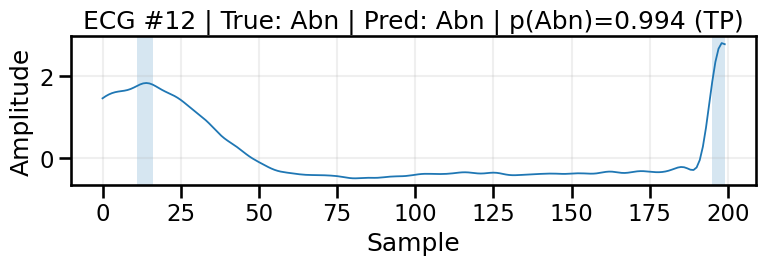

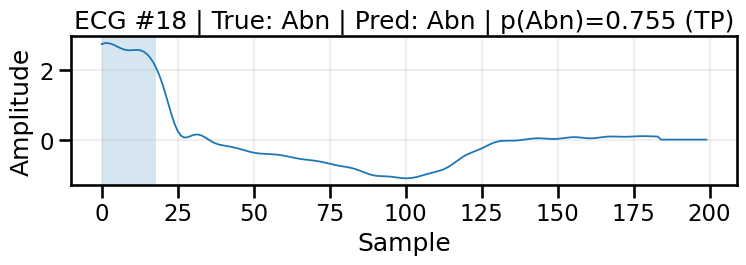

Plotting False Positives (predicted Abnormal, actually Normal):


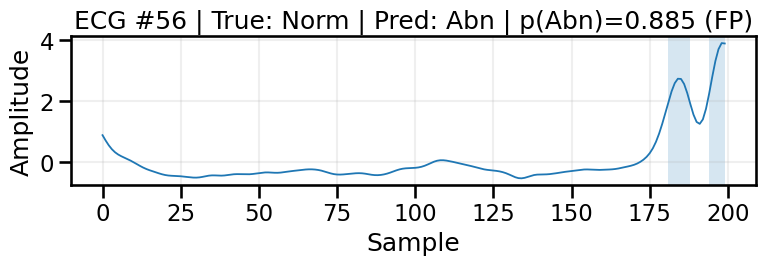

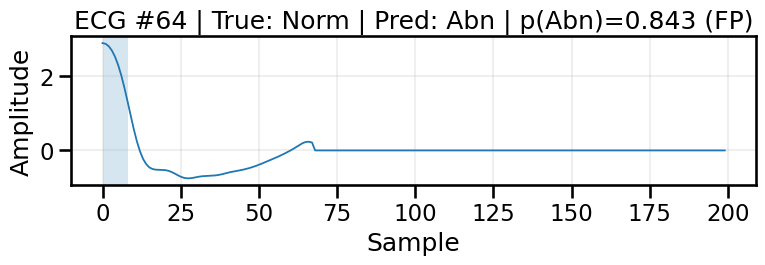

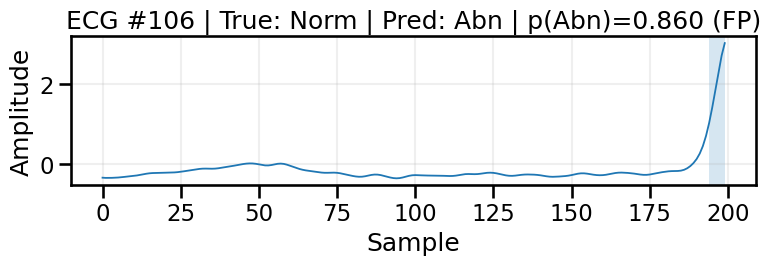

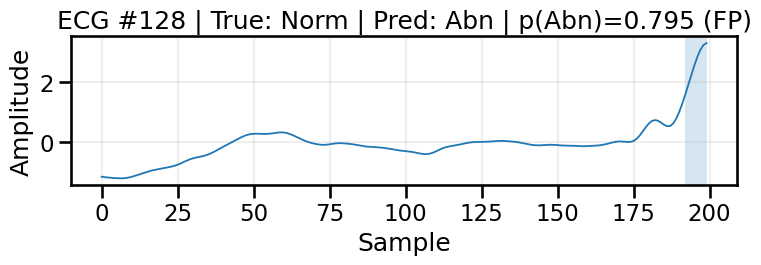

Plotting False Negatives (predicted Normal, actually Abnormal):


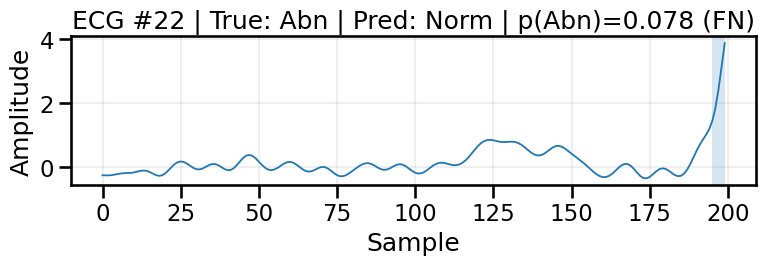

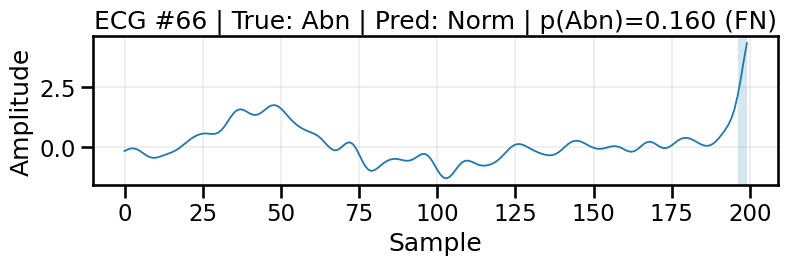

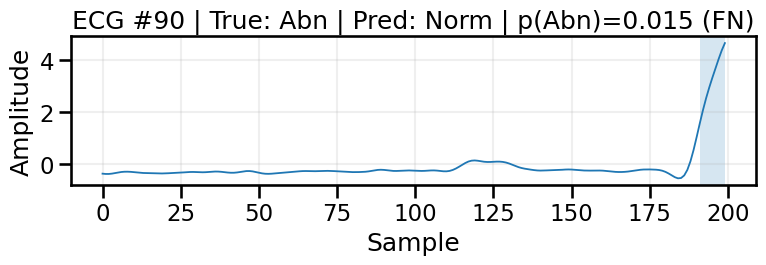

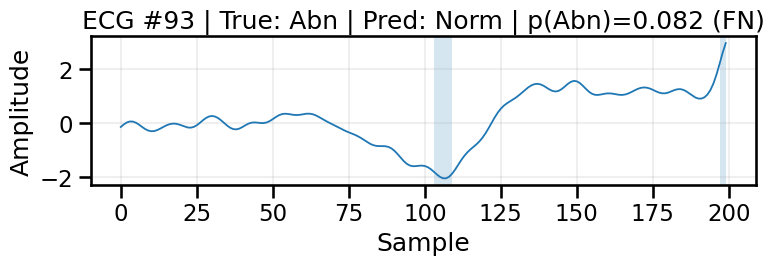

Plotting True Negatives (predicted Normal, actually Normal):


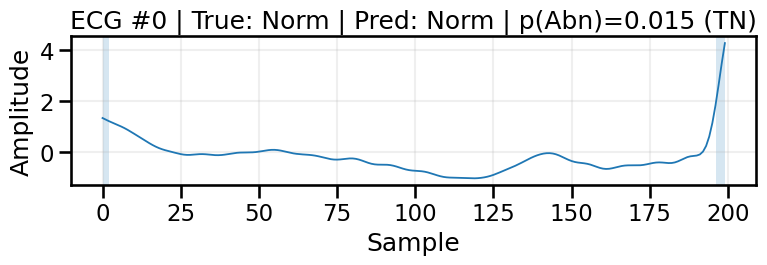

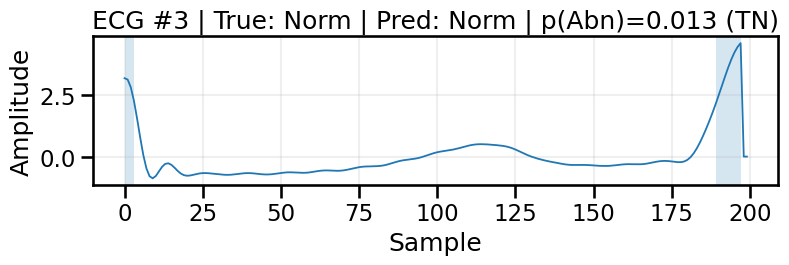

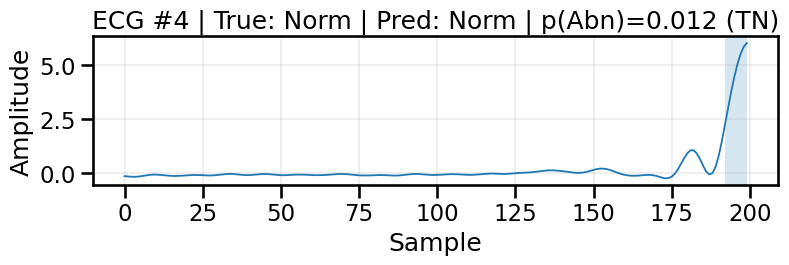

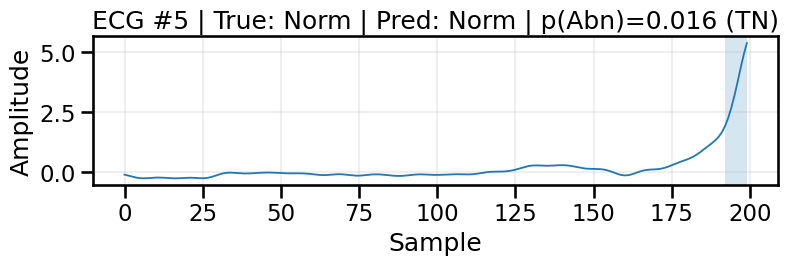

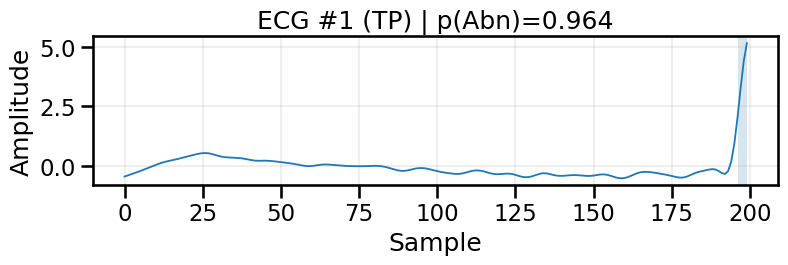


Saved figures: ['confusion_matrices.png', 'roc_curve.png', 'pr_curve.png', 'ecg_tp_example.png']


In [29]:
# ===== Evaluation & Visualization (run after training) =====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

os.makedirs(MODEL_DIR, exist_ok=True)

# ---- Rebuild test probabilities robustly (no hybrid dependency) ----
# Base model probs
rf_test_prob  = rf_full.predict_proba(Xtab_test_scaled)[:, 1]
xgb_test_prob = xgb_full.predict_proba(Xtab_test_scaled)[:, 1]
lgb_test_prob = lgb_full.predict(Xtab_test_scaled)

# Meta features from base probs
meta_test_feats = np.column_stack([rf_test_prob, xgb_test_prob, lgb_test_prob])

# Meta (stacked) probability and predictions
meta_probs  = meta_lr.predict_proba(meta_test_feats)[:, 1]
final_probs = meta_probs  # <- use stacked meta as final (no undefined hybrid)
final_preds = (final_probs >= 0.5).astype(int)

print("Final (meta-stacked) Test Metrics")
print(classification_report(y_test, final_preds, target_names=["Normal", "Abnormal"]))
print("Accuracy:", accuracy_score(y_test, final_preds))

# ===== 1) Confusion Matrix (Counts + Normalized) =====
cm = confusion_matrix(y_test, final_preds, labels=[0,1])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"])
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.2f', ax=ax[1], xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"])
ax[1].set_title("Confusion Matrix (Normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(MODEL_DIR, "confusion_matrices.png"), dpi=150)

# ===== 2) ROC Curve =====
fpr, tpr, _ = roc_curve(y_test, final_probs)
roc_auc = roc_auc_score(y_test, final_probs)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Meta-Stacked)")
plt.legend()
plt.tight_layout()
plt.show()
plt.gcf().savefig(os.path.join(MODEL_DIR, "roc_curve.png"), dpi=150)

# ===== 3) Precision–Recall Curve =====
prec, rec, _ = precision_recall_curve(y_test, final_probs)
ap = average_precision_score(y_test, final_probs)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (Meta-Stacked)")
plt.legend()
plt.tight_layout()
plt.show()
plt.gcf().savefig(os.path.join(MODEL_DIR, "pr_curve.png"), dpi=150)

# ===== 4) ECG Plotting with Anomalies Highlighted =====
# We'll detect "within-beat anomalies" by simple z-score thresholding (|z| > 2) for visualization.
# Also provide helpers to sample TP/FP/FN beats.

def _highlight_regions(ax, x, mask, alpha=0.25):
    """Shade regions where mask==True."""
    if mask.sum() == 0:
        return
    # Find contiguous segments
    idx = np.where(mask)[0]
    # Split when gap > 1
    splits = np.where(np.diff(idx) > 1)[0]
    segments = np.split(idx, splits + 1)
    for seg in segments:
        ax.axvspan(seg[0], seg[-1], alpha=alpha)

def plot_ecg(idx, title_extra=""):
    """Plot a single ECG beat with anomaly highlights by z-score."""
    sig = Xsig_test[idx].astype(float)
    # Z-score (avoid div by zero)
    mu, sd = sig.mean(), sig.std() if sig.std() > 1e-8 else 1.0
    z = (sig - mu) / sd
    anomaly_mask = np.abs(z) > 2.0  # threshold for 'anomalous' points (purely for visualization)

    tl = y_test[idx]
    pl = final_preds[idx]
    prob = final_probs[idx]

    plt.figure(figsize=(8,3))
    ax = plt.gca()
    ax.plot(sig, lw=1.3)
    _highlight_regions(ax, np.arange(len(sig)), anomaly_mask, alpha=0.18)
    ax.set_title(f"ECG #{idx} | True: {'Abn' if tl==1 else 'Norm'} | Pred: {'Abn' if pl==1 else 'Norm'} | p(Abn)={prob:.3f} {title_extra}")
    ax.set_xlabel("Sample"); ax.set_ylabel("Amplitude")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def sample_indices_by_outcome(max_per_group=4):
    """Return example indices for TP/FP/FN (and TN if needed)."""
    y_true = y_test
    y_pred = final_preds
    idxs = np.arange(len(y_true))

    TP = idxs[(y_true==1) & (y_pred==1)][:max_per_group]
    FP = idxs[(y_true==0) & (y_pred==1)][:max_per_group]
    FN = idxs[(y_true==1) & (y_pred==0)][:max_per_group]
    TN = idxs[(y_true==0) & (y_pred==0)][:max_per_group]
    return TP, FP, FN, TN

# --- Show a few examples per outcome ---
TP, FP, FN, TN = sample_indices_by_outcome(max_per_group=4)

print("\nPlotting True Positives (predicted Abnormal, actually Abnormal):")
for i in TP: plot_ecg(int(i), title_extra="(TP)")

print("Plotting False Positives (predicted Abnormal, actually Normal):")
for i in FP: plot_ecg(int(i), title_extra="(FP)")

print("Plotting False Negatives (predicted Normal, actually Abnormal):")
for i in FN: plot_ecg(int(i), title_extra="(FN)")

# Optionally some TNs too (comment out if not needed)
print("Plotting True Negatives (predicted Normal, actually Normal):")
for i in TN: plot_ecg(int(i), title_extra="(TN)")

# Save a representative figure to disk as well:
if len(TP) > 0:
    # Save the first TP beat plot to file
    idx = int(TP[0])
    sig = Xsig_test[idx].astype(float)
    mu, sd = sig.mean(), sig.std() if sig.std() > 1e-8 else 1.0
    z = (sig - mu) / sd
    anomaly_mask = np.abs(z) > 2.0

    plt.figure(figsize=(8,3))
    ax = plt.gca()
    ax.plot(sig, lw=1.3)
    _highlight_regions(ax, np.arange(len(sig)), anomaly_mask, alpha=0.18)
    ax.set_title(f"ECG #{idx} (TP) | p(Abn)={final_probs[idx]:.3f}")
    ax.set_xlabel("Sample"); ax.set_ylabel("Amplitude")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.gcf().savefig(os.path.join(MODEL_DIR, "ecg_tp_example.png"), dpi=150)
    plt.show()

print("\nSaved figures:", [
    "confusion_matrices.png",
    "roc_curve.png",
    "pr_curve.png",
    "ecg_tp_example.png"
])


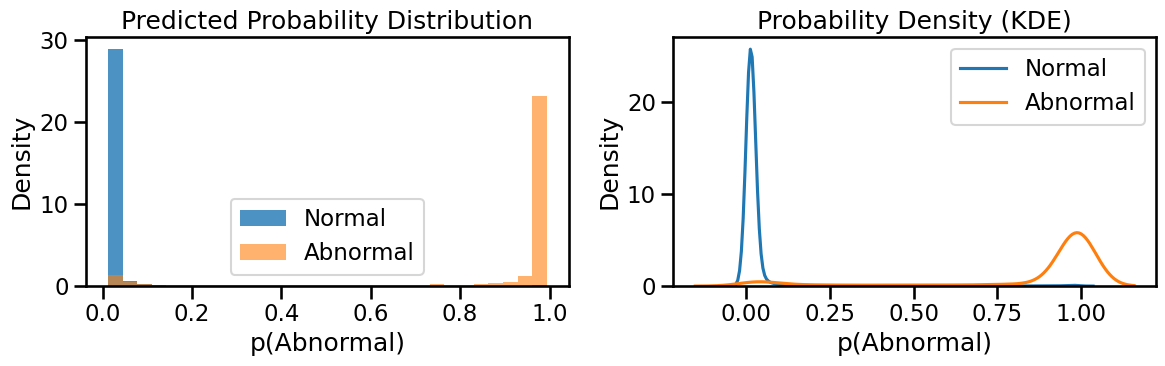

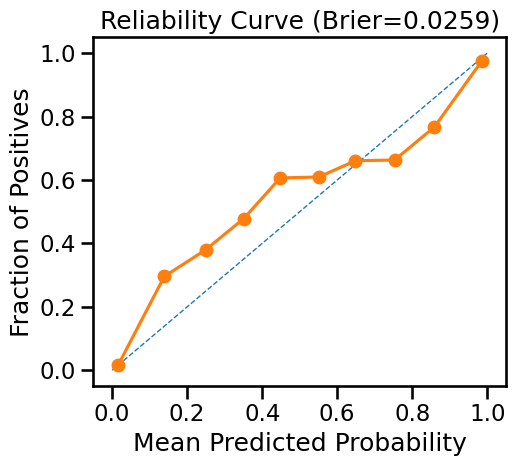

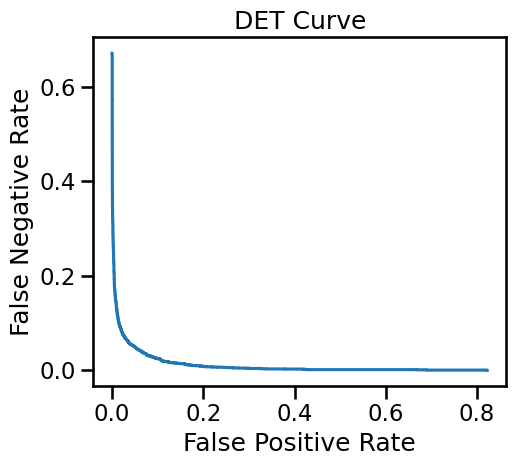

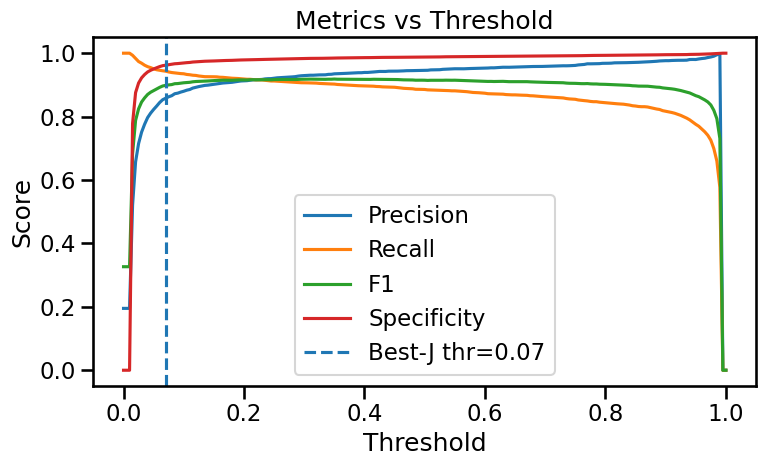

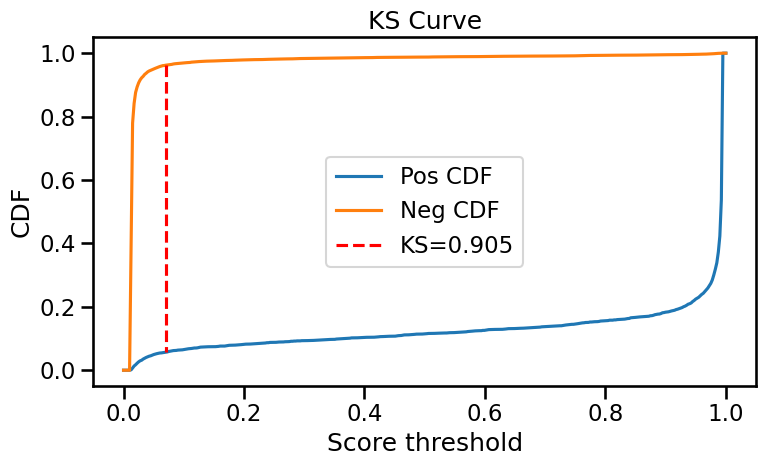

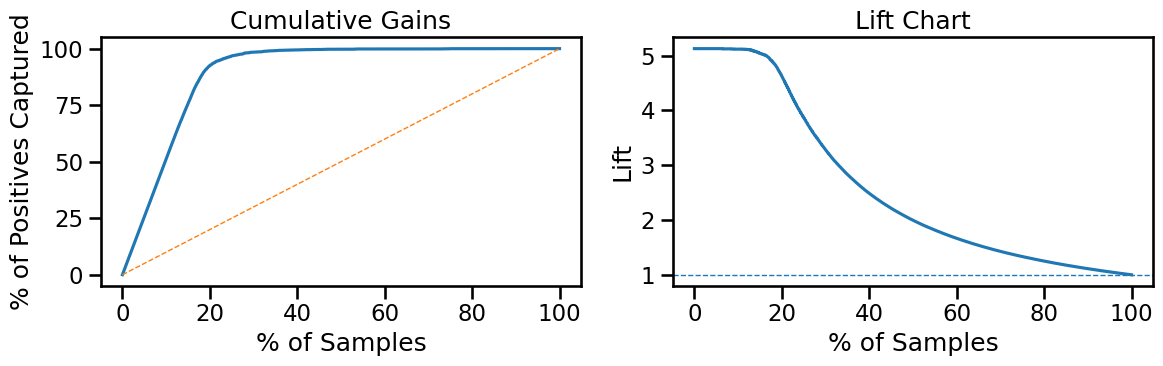

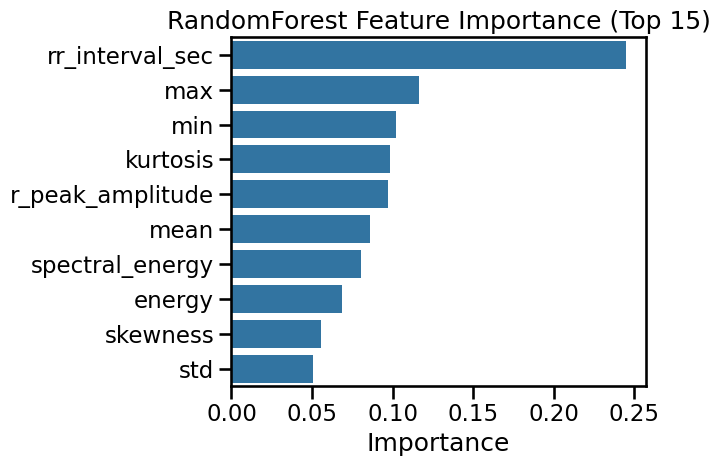

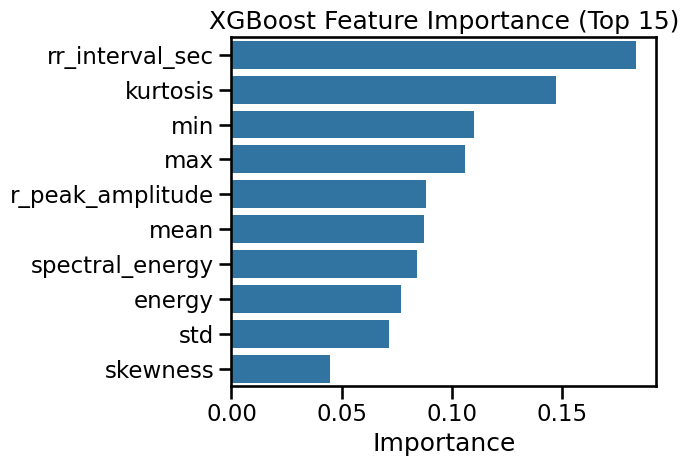

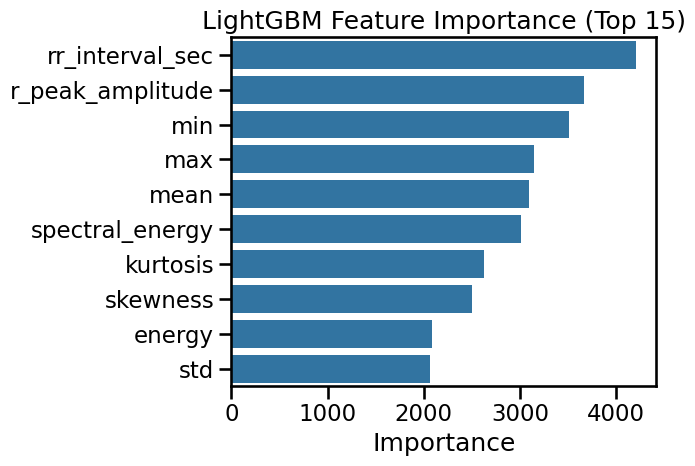

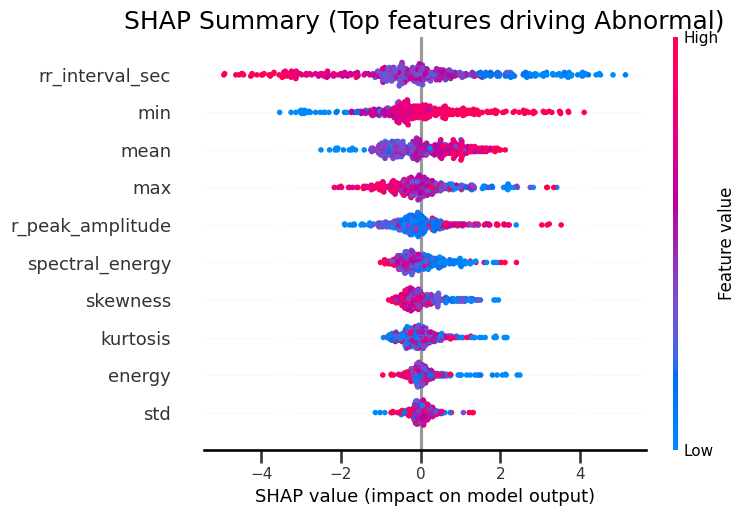

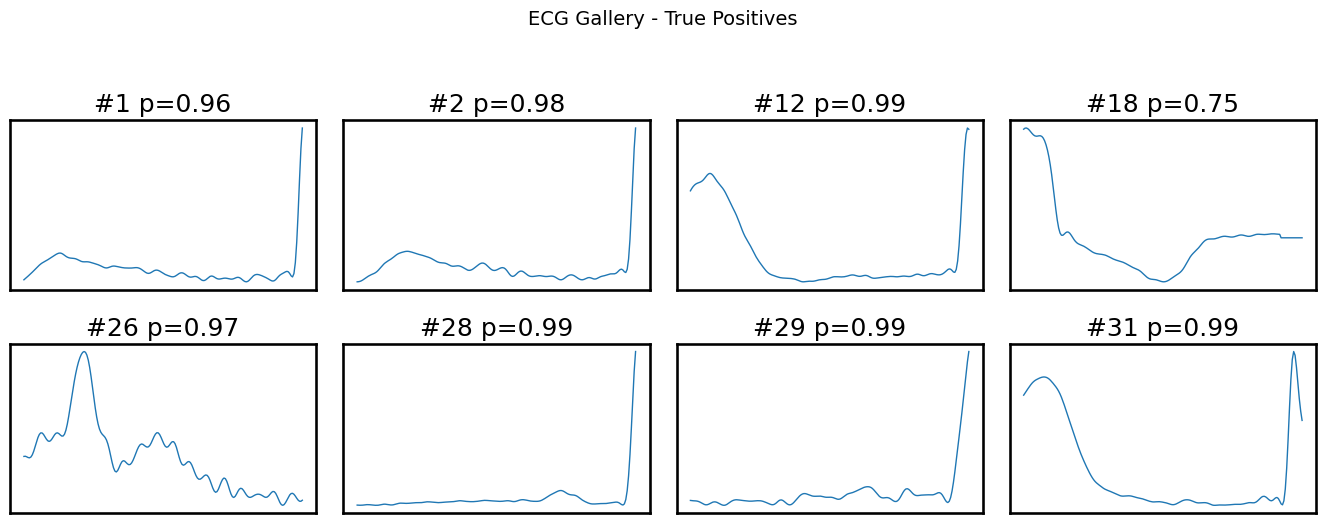

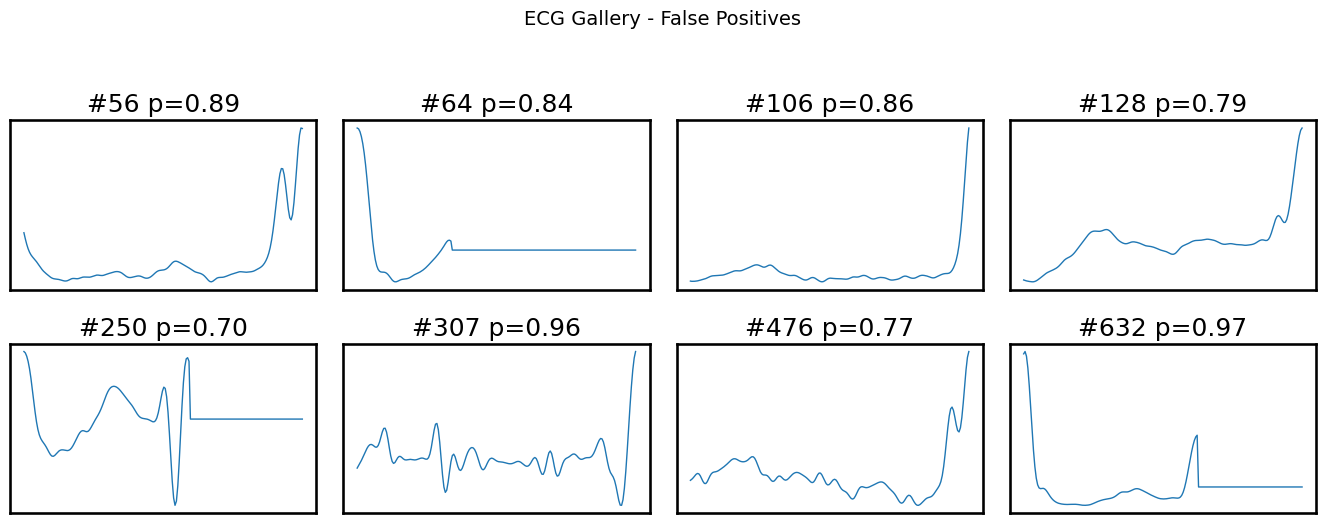

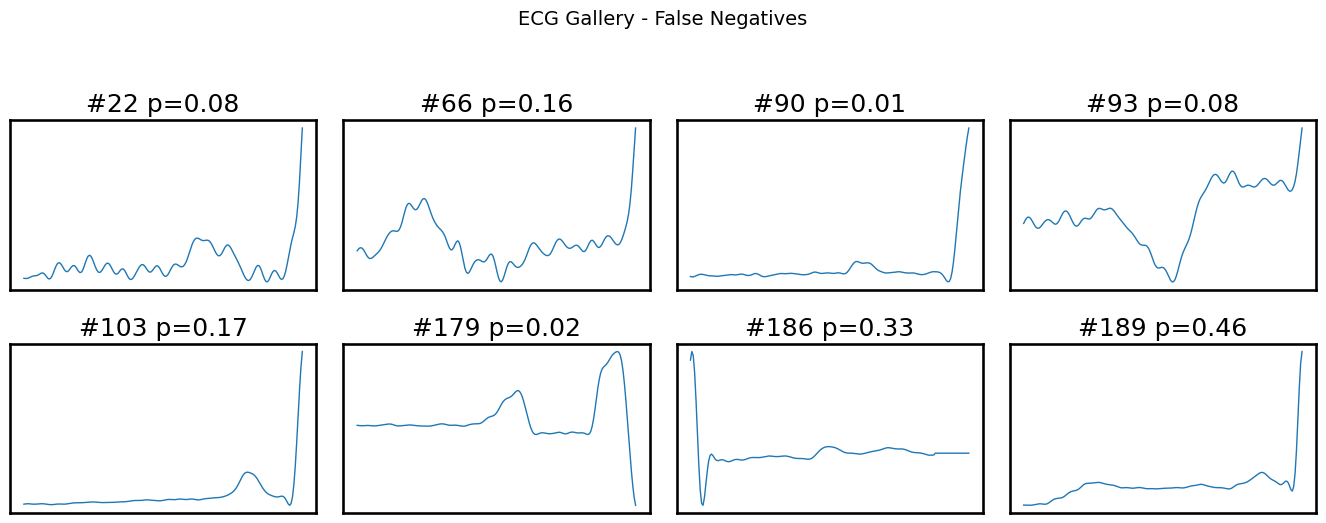

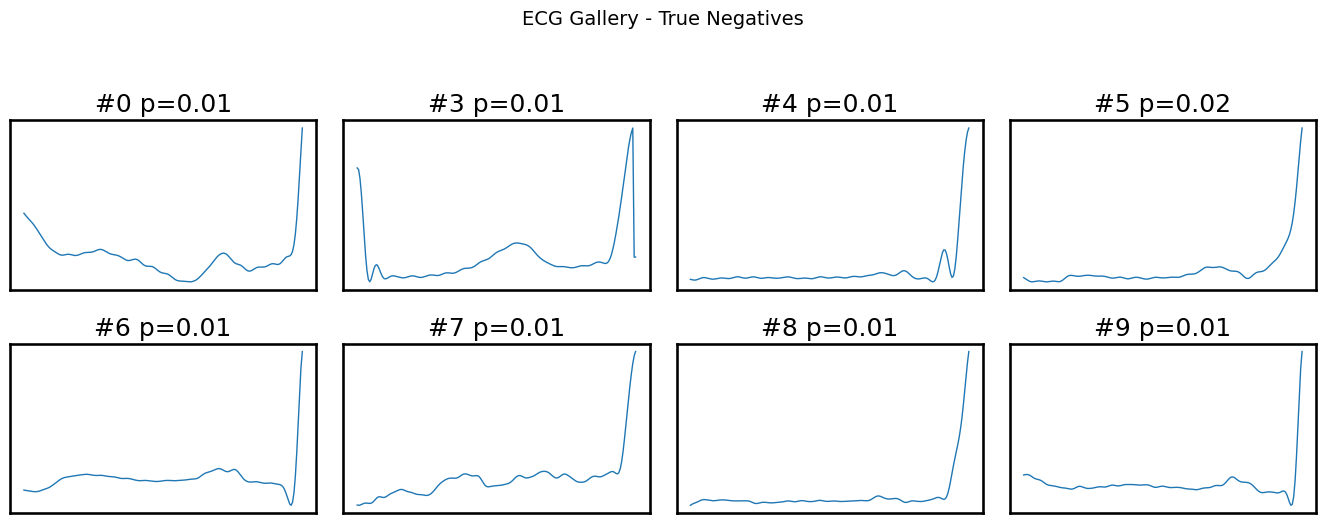


Use the slider to see how the threshold changes the confusion matrix:


interactive(children=(FloatSlider(value=0.07, description='thr', max=1.0, step=0.01), Output()), _dom_classes=…

In [28]:
# ===================== RICH EVALUATION VISUALS =====================
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score,
    average_precision_score, det_curve
)
from sklearn.calibration import calibration_curve
from ipywidgets import interact, FloatSlider
warnings.filterwarnings("ignore")

os.makedirs(MODEL_DIR, exist_ok=True)
sns.set_context("talk")

# --------- Helpers ---------
def ensure_vec(x):
    return np.asarray(x).reshape(-1)

y_true = ensure_vec(y_test)
probs  = ensure_vec(final_probs)  # from your meta-stacked model
preds  = (probs >= 0.5).astype(int)

def save_show(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()

# --------- 0) Probability Distributions by Class ---------
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(probs[y_true==0], bins=30, alpha=0.8, label="Normal", density=True)
ax[0].hist(probs[y_true==1], bins=30, alpha=0.6, label="Abnormal", density=True)
ax[0].set_title("Predicted Probability Distribution")
ax[0].set_xlabel("p(Abnormal)"); ax[0].set_ylabel("Density"); ax[0].legend()

sns.kdeplot(x=probs[y_true==0], ax=ax[1], label="Normal")
sns.kdeplot(x=probs[y_true==1], ax=ax[1], label="Abnormal")
ax[1].set_title("Probability Density (KDE)")
ax[1].set_xlabel("p(Abnormal)"); ax[1].legend()

save_show(fig, os.path.join(MODEL_DIR, "prob_dists.png"))

# --------- 1) Calibration (Reliability) Curve + Brier Score ---------
prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10, strategy="uniform")
brier = np.mean((probs - y_true)**2)

fig, ax = plt.subplots(figsize=(5.5,5))
ax.plot([0,1], [0,1], "--", lw=1)
ax.plot(prob_pred, prob_true, marker="o")
ax.set_title(f"Reliability Curve (Brier={brier:.4f})")
ax.set_xlabel("Mean Predicted Probability"); ax.set_ylabel("Fraction of Positives")
save_show(fig, os.path.join(MODEL_DIR, "calibration_curve.png"))

# --------- 2) DET Curve ---------
fpr, fnr, _ = det_curve(y_true, probs)
fig, ax = plt.subplots(figsize=(5.5,5))
ax.plot(fpr, fnr)
ax.set_title("DET Curve")
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("False Negative Rate")
save_show(fig, os.path.join(MODEL_DIR, "det_curve.png"))

# --------- 3) Threshold Sweep (Precision/Recall/F1/Specificity) ---------
prec, rec, thr_pr = precision_recall_curve(y_true, probs)
# To compute metrics vs threshold uniformly:
thrs = np.linspace(0.0, 1.0, 201)
precisions, recalls, f1s, specs = [], [], [], []
for t in thrs:
    p = (probs >= t).astype(int)
    TP = np.sum((y_true==1)&(p==1))
    FP = np.sum((y_true==0)&(p==1))
    FN = np.sum((y_true==1)&(p==0))
    TN = np.sum((y_true==0)&(p==0))
    precision = TP / (TP+FP+1e-9)
    recall    = TP / (TP+FN+1e-9)
    f1        = 2*precision*recall/(precision+recall+1e-9)
    specificity = TN / (TN+FP+1e-9)
    precisions.append(precision); recalls.append(recall); f1s.append(f1); specs.append(specificity)

# Youden's J to propose an operating threshold
youden = np.array(recalls) + np.array(specs) - 1
best_idx = int(np.argmax(youden))
best_thr = thrs[best_idx]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thrs, precisions, label="Precision")
ax.plot(thrs, recalls, label="Recall")
ax.plot(thrs, f1s, label="F1")
ax.plot(thrs, specs, label="Specificity")
ax.axvline(best_thr, ls="--", label=f"Best-J thr={best_thr:.2f}")
ax.set_title("Metrics vs Threshold")
ax.set_xlabel("Threshold"); ax.set_ylabel("Score")
ax.legend()
save_show(fig, os.path.join(MODEL_DIR, "threshold_sweep.png"))

# --------- 4) KS Curve ---------
# Empirical CDFs of scores by class
pos_scores = np.sort(probs[y_true==1])
neg_scores = np.sort(probs[y_true==0])
grid = np.linspace(0,1,400)
cdf_pos = [np.mean(pos_scores <= g) for g in grid]
cdf_neg = [np.mean(neg_scores <= g) for g in grid]
cdf_pos, cdf_neg = np.array(cdf_pos), np.array(cdf_neg)
ks_vals = np.abs(cdf_pos - cdf_neg)
ks = ks_vals.max()
ks_t = grid[ks_vals.argmax()]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(grid, cdf_pos, label="Pos CDF")
ax.plot(grid, cdf_neg, label="Neg CDF")
ax.vlines(ks_t, cdf_neg[ks_vals.argmax()], cdf_pos[ks_vals.argmax()], colors="r", linestyles="--", label=f"KS={ks:.3f}")
ax.set_title("KS Curve")
ax.set_xlabel("Score threshold"); ax.set_ylabel("CDF")
ax.legend()
save_show(fig, os.path.join(MODEL_DIR, "ks_curve.png"))

# --------- 5) Lift & Cumulative Gains ---------
order = np.argsort(-probs)
y_sorted = y_true[order]
cum_pos = np.cumsum(y_sorted==1)
total_pos = np.sum(y_true==1)
percentile = np.arange(1, len(y_true)+1)/len(y_true)
gains = cum_pos / (total_pos + 1e-9)

lift = gains / percentile
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(percentile*100, gains*100)
ax[0].plot([0,100],[0,100], "--", lw=1)
ax[0].set_title("Cumulative Gains"); ax[0].set_xlabel("% of Samples"); ax[0].set_ylabel("% of Positives Captured")

ax[1].plot(percentile*100, lift)
ax[1].axhline(1.0, ls="--", lw=1)
ax[1].set_title("Lift Chart"); ax[1].set_xlabel("% of Samples"); ax[1].set_ylabel("Lift")
save_show(fig, os.path.join(MODEL_DIR, "gains_lift.png"))

# --------- 6) Feature Importances (RF / XGB / LGB) ---------
def _feat_names():
    try:
        return list(tabular_cols)
    except:
        return [f"feat_{i}" for i in range(Xtab_test_scaled.shape[1])]

feat_names = _feat_names()

def plot_importances(importances, title, save_as):
    idx = np.argsort(importances)[::-1][:15]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(x=importances[idx], y=np.array(feat_names)[idx], ax=ax, orient="h")
    ax.set_title(title); ax.set_xlabel("Importance"); ax.set_ylabel("")
    save_show(fig, os.path.join(MODEL_DIR, save_as))

# RF
try:
    imp_rf = rf_full.feature_importances_
    plot_importances(imp_rf, "RandomForest Feature Importance (Top 15)", "fi_rf.png")
except Exception as e:
    print("RF importance skipped:", e)

# XGB
try:
    imp_xgb = xgb_full.feature_importances_
    plot_importances(imp_xgb, "XGBoost Feature Importance (Top 15)", "fi_xgb.png")
except Exception as e:
    print("XGB importance skipped:", e)

# LGB
try:
    imp_lgb = lgb_full.feature_importance()
    plot_importances(imp_lgb, "LightGBM Feature Importance (Top 15)", "fi_lgb.png")
except Exception as e:
    print("LGB importance skipped:", e)

# --------- 7) Optional SHAP (auto-skip if not installed) ---------
try:
    import shap
    shap.initjs()
    # Use LGB if available (fast), else XGB
    explainer_model = None
    X_sample = Xtab_test_scaled[:400]
    if 'lgb_full' in globals() and lgb_full is not None:
        explainer_model = shap.TreeExplainer(lgb_full)
    elif 'xgb_full' in globals() and xgb_full is not None:
        explainer_model = shap.TreeExplainer(xgb_full)

    if explainer_model is not None:
        shap_vals = explainer_model.shap_values(X_sample)
        # Binary: shap_values can be [class0, class1]; pick positive class if list
        if isinstance(shap_vals, list) and len(shap_vals) == 2:
            shap_vals = shap_vals[1]
        fig = plt.figure(figsize=(8,5))
        shap.summary_plot(shap_vals, X_sample, feature_names=feat_names, show=False)
        plt.title("SHAP Summary (Top features driving Abnormal)")
        save_show(plt.gcf(), os.path.join(MODEL_DIR, "shap_summary.png"))
    else:
        print("SHAP: No tree model available for explainer.")
except Exception as e:
    print("SHAP skipped:", e)

# --------- 8) ECG Gallery Grids (TP/FP/FN/TN) ---------
def sample_indices_by_outcome(max_per_group=8):
    idxs = np.arange(len(y_true))
    TP = idxs[(y_true==1)&(preds==1)][:max_per_group]
    FP = idxs[(y_true==0)&(preds==1)][:max_per_group]
    FN = idxs[(y_true==1)&(preds==0)][:max_per_group]
    TN = idxs[(y_true==0)&(preds==0)][:max_per_group]
    return TP, FP, FN, TN

def plot_ecg_grid(idxs, title):
    if len(idxs) == 0:
        print(f"No samples for {title}")
        return
    cols = 4
    rows = int(np.ceil(len(idxs)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.4, rows*2.6), squeeze=False)
    for i, idx in enumerate(idxs):
        r, c = divmod(i, cols)
        sig = Xsig_test[int(idx)].astype(float)
        axes[r][c].plot(sig, lw=1.0)
        axes[r][c].set_title(f"#{idx} p={probs[int(idx)]:.2f}")
        axes[r][c].set_xticks([]); axes[r][c].set_yticks([])
    # hide empty cells
    for j in range(len(idxs), rows*cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")
    fig.suptitle(title, y=1.02, fontsize=14)
    save_show(fig, os.path.join(MODEL_DIR, f"{title.lower().replace(' ','_')}.png"))

TP, FP, FN, TN = sample_indices_by_outcome(max_per_group=8)
plot_ecg_grid(TP, "ECG Gallery - True Positives")
plot_ecg_grid(FP, "ECG Gallery - False Positives")
plot_ecg_grid(FN, "ECG Gallery - False Negatives")
plot_ecg_grid(TN, "ECG Gallery - True Negatives")

# --------- 9) Interactive threshold: confusion matrix updates ---------
def cm_at_threshold(thr=0.5):
    p = (probs >= thr).astype(int)
    cm = confusion_matrix(y_true, p, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"], ax=ax)
    ax.set_title(f"Confusion Matrix @ thr={thr:.2f}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.show()

print("\nUse the slider to see how the threshold changes the confusion matrix:")
interact(cm_at_threshold, thr=FloatSlider(value=float(best_thr), min=0.0, max=1.0, step=0.01));
